In [0]:
# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

# Lectura de datos

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [0]:
diabetes = pd.read_csv("./datos/diabetes.csv")

In [151]:
diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [152]:
diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634599e-16,1.296411e-16,-8.042209e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.575274e-16,3.780755e-16,-3.830854e-16,-3.411950e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


Como podemos ver en la tabla anterior, algunos valores son negativos, por lo que vamos a escalar los valores entre 0 y 1

In [0]:
scaler = MinMaxScaler()
diabetes_norm = pd.DataFrame(scaler.fit_transform(diabetes))

Datos despues de ser escalados

In [156]:
diabetes_norm.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,0.491968,0.468326,0.346107,0.459818,0.451668,0.367725,0.360889,0.291996,0.485557,0.503942,0.396054
std,0.218484,0.499561,0.182567,0.194806,0.169647,0.151460,0.167977,0.182010,0.183364,0.174187,0.240165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.320833,0.000000,0.214876,0.309859,0.329657,0.271165,0.237013,0.141044,0.357528,0.382576,0.193146
50%,0.516667,0.000000,0.318182,0.436620,0.436275,0.355578,0.337662,0.282087,0.478057,0.500000,0.359813
75%,0.666667,1.000000,0.465909,0.605634,0.552696,0.462649,0.464286,0.423131,0.610446,0.606061,0.580997
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
diabetes_norm = diabetes_norm.rename(columns={0:'age',1:'sex', 2:'bmi', 3:'bp', 4:'s1',5:'s2',6:'s3',7:'s4',8:'s5',9:'s6',10:'Y'})

In [158]:
diabetes_norm.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.666667,1.0,0.582645,0.549296,0.294118,0.256972,0.207792,0.282087,0.562217,0.439394,0.392523
1,0.483333,0.0,0.148760,0.352113,0.421569,0.306773,0.623377,0.141044,0.222443,0.166667,0.155763
2,0.883333,1.0,0.516529,0.436620,0.289216,0.258964,0.246753,0.282087,0.496584,0.409091,0.361371
3,0.083333,0.0,0.301653,0.309859,0.495098,0.447211,0.233766,0.423131,0.572936,0.469697,0.563863
4,0.516667,0.0,0.206612,0.549296,0.465686,0.417331,0.389610,0.282087,0.362369,0.333333,0.342679


# Variables significativas
Para determinar cuales de las variables son significativas en nuestro problema, que es determinar la progresión de la enfermedad, primero se hallará un gráfico de dispersiones y posteriormente una matriz de correlaciones.

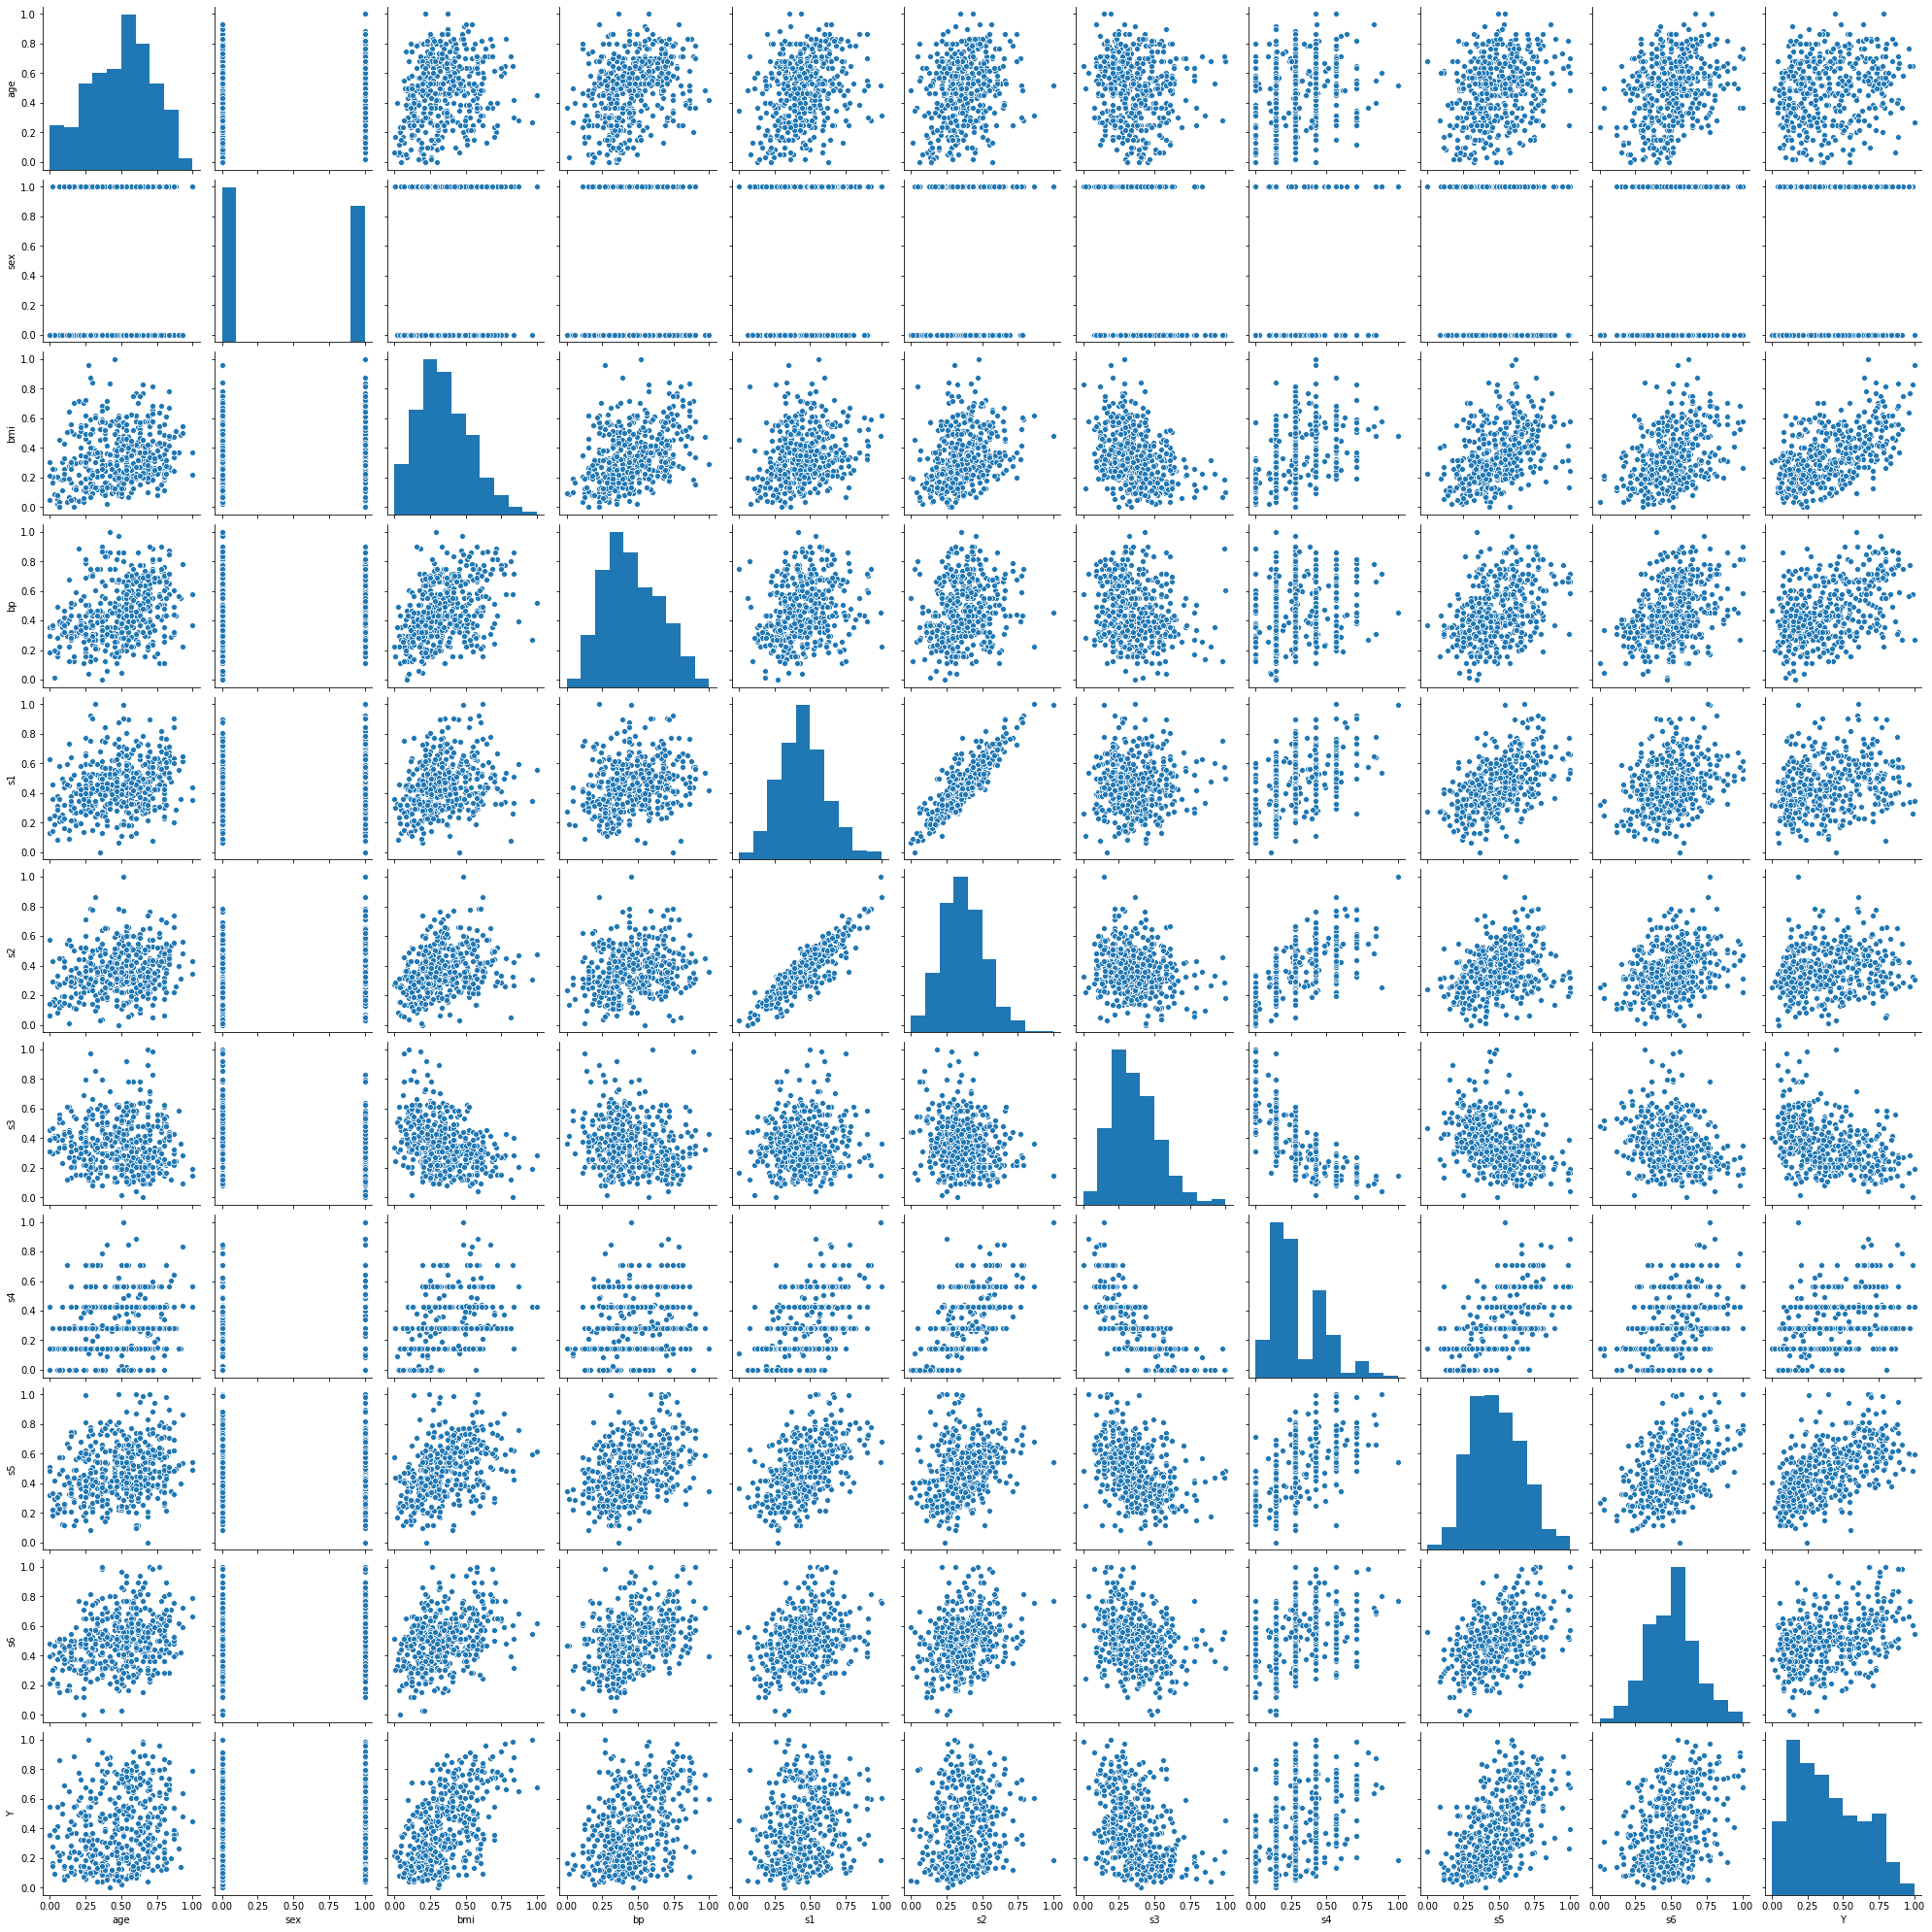

In [21]:

sb.pairplot(diabetes_norm, kind='scatter')

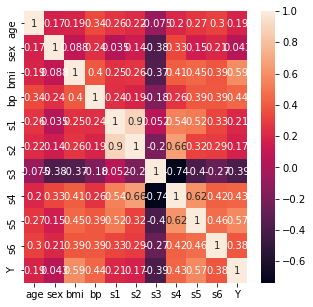

In [17]:
corrMatrix = diabetes_norm.corr()
sb.heatmap(corrMatrix, annot=True)

Como podemos apreciar con los gráficos anteriores tenemos que las variables bmi, bp,s5, s4 parecen ser las que más tienen correlación positiva con Y, mientras que la variable sex tiene algo de correlación negativa, así que determinamos que estas variables son las mas significativas para nuestro modelo

# Modelo lineal




In [0]:
def lineal(x, y):
  xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

  reg = linear_model.LinearRegression()
  reg.fit(xtrain, ytrain)
  ypred = reg.predict(xtest)
  print("SME: %.2f" % mean_squared_error(ytest, ypred))
  print("Coficiente R^2: %.2f" % reg.score(xtest, ytest))

  scores = cross_val_score(reg, x, y, cv=5)
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

  plt.figure(figsize=(7, 7))
  ytest['ypred'] = ypred
  sb.scatterplot(x='Y', y='ypred', data= ytest)
  plt.plot([0, 1], [0, 1], color='black')
  plt.ylim(0,1)

In [0]:
X = diabetes_norm.loc[:,['sex', 'bmi', 'bp', 's4','s5']]
Y = diabetes_norm.loc[:,['Y']]

## Ahora se entrena un modelo lineal básico

SME: 0.03
Coficiente R^2: 0.34
Accuracy: 0.47 (+/- 0.09)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


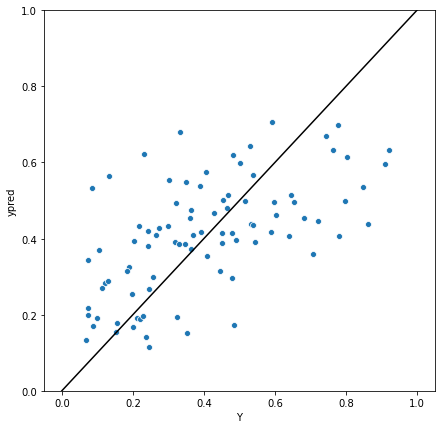

In [179]:
lineal(X,Y)

## Modelo lineal transformando la variable dependiente Y

In [0]:
y_sqrt = Y.apply(lambda x: np.sqrt(x))

SME: 0.02
Coficiente R^2: 0.35
Accuracy: 0.45 (+/- 0.08)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


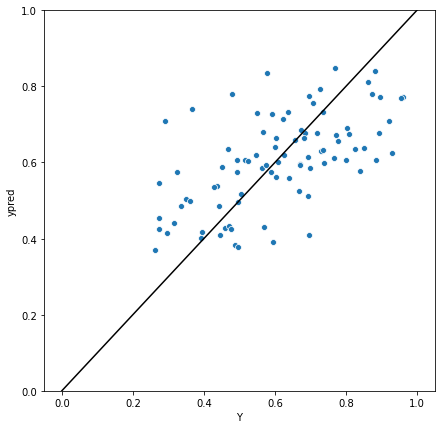

In [181]:
lineal(X,y_sqrt)

## Transformamos bmi a sqrt(bmi)

In [0]:
x1 = X.copy()

In [0]:
x1['bmi'] = x1['bmi'].apply(lambda x: np.sqrt(x))

SME: 0.03
Coficiente R^2: 0.33
Accuracy: 0.45 (+/- 0.09)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


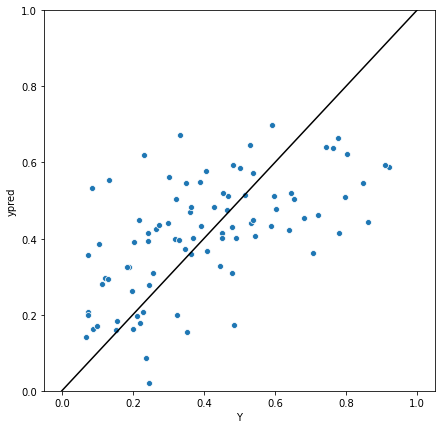

In [184]:
lineal(x1, Y)

## Transformamos todas las variables a su sqrt

In [0]:
x2 = X.apply(lambda x: np.sqrt(x))

SME: 0.03
Coficiente R^2: 0.34
Accuracy: 0.44 (+/- 0.09)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


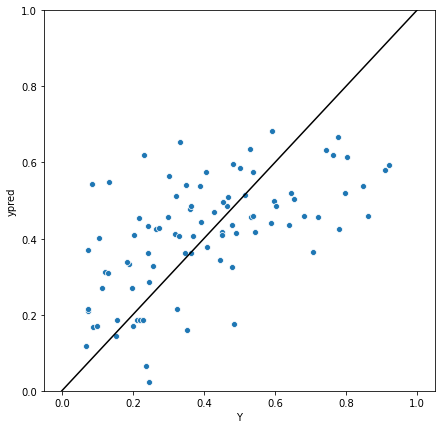

In [186]:
lineal(x2,Y)

## Transformando bmi a cbrt(bmi)

In [0]:
x3 = X.copy()
x3['bmi'] = x3['bmi'].apply(lambda x: np.cbrt(x))

SME: 0.03
Coficiente R^2: 0.33
Accuracy: 0.44 (+/- 0.08)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


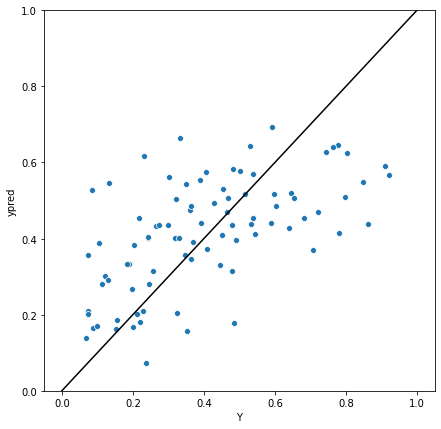

In [188]:
lineal(x3, Y)

## Transformando bmi y bp a sus raices cúbicas

In [0]:
x4 = X.copy()
x4['bmi'] = x4['bmi'].apply(lambda x: np.cbrt(x))
x4['bp'] = x4['bp'].apply(lambda x: np.cbrt(x))

SME: 0.03
Coficiente R^2: 0.32
Accuracy: 0.43 (+/- 0.08)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


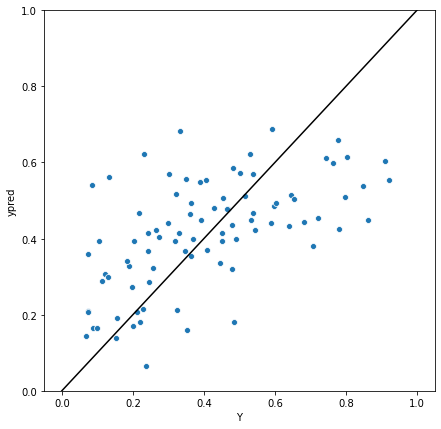

In [191]:
lineal(x4, Y)

## Modelo con todas las variables independientes con su raíz cúbica

In [0]:
x5 = X.apply(lambda x: np.cbrt(x))

SME: 0.03
Coficiente R^2: 0.33
Accuracy: 0.41 (+/- 0.10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


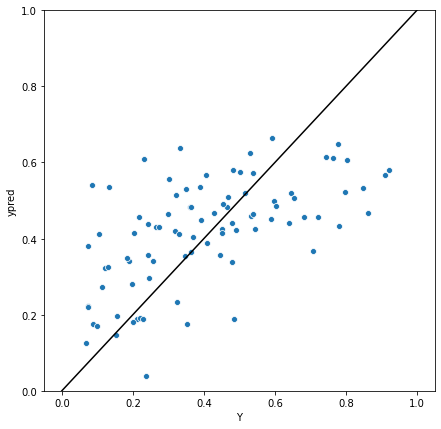

In [216]:
lineal(x5, Y)

## Modelo con la variable bmi elevada al cuadrado

In [0]:
x5 = X.copy()
x5['bmi'] = x5['bmi'].apply(lambda x: np.square(x))

SME: 0.03
Coficiente R^2: 0.36
Accuracy: 0.47 (+/- 0.06)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


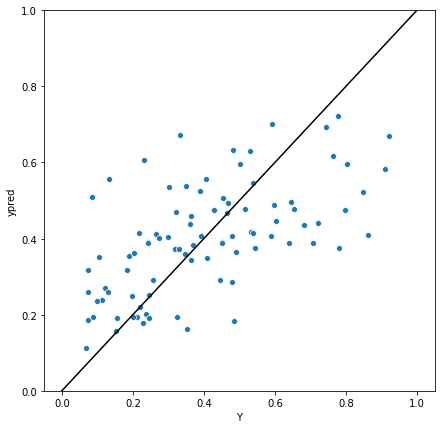

In [218]:
lineal(x5, Y)

## Variables bmi y bp elevadas al cuadrado

In [0]:
x6 = X.copy()
x6['bmi'] = x6['bmi'].apply(lambda x: np.square(x))
x6['bp'] = x6['bp'].apply(lambda x: np.square(x))

SME: 0.03
Coficiente R^2: 0.36
Accuracy: 0.48 (+/- 0.06)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


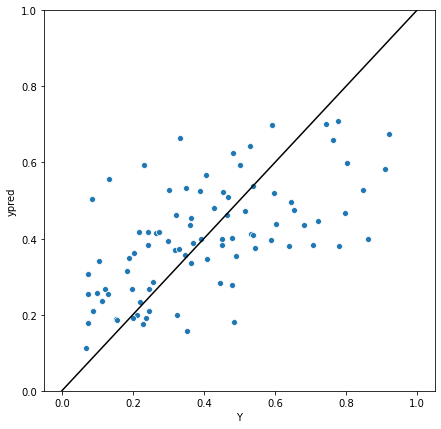

In [220]:
lineal(x6, Y)

## Todas las variables independientes elevadas al cuadrado

In [0]:
x7 = X.apply(lambda x: np.square(x))

SME: 0.03
Coficiente R^2: 0.34
Accuracy: 0.46 (+/- 0.06)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


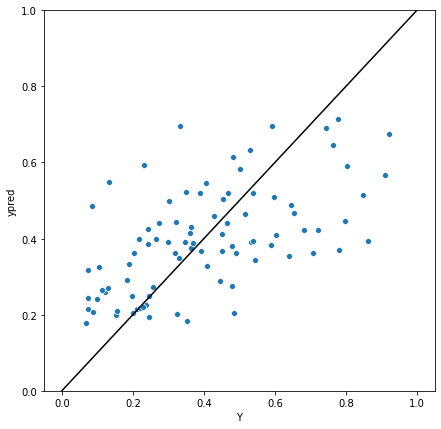

In [223]:
lineal(x7, Y)

# Conclusión modelos lineales
Podemos ver como a pesar de las transformaciones llevadas a cabo, no se encuentran grandes variaciones entre ellas. Pero podemos determinar que escogeremos el modelo de referencia como el modelo con las variables bmi y bp elevadas al cuadrado, el  cual obtuvo una exactitud de validacion mediante la tenica de validación cruzada de 0.48 +- 0.06

# Red neuronal

In [0]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [268]:
np.random.seed(0)

rn = MLPRegressor(hidden_layer_sizes=(5, ),
                 activation = 'identity',
                 learning_rate = 'adaptive',
                 solver= 'sgd',
                 shuffle = True,
                 learning_rate_init = 0.01,
                 max_iter = 500)

rn.fit(xtrain,  ytrain.values.ravel())

scores = cross_val_score(rn, X, Y.values.ravel(), cv=5,scoring = 'neg_mean_squared_error')
print("MSE",round(np.mean(abs(scores)),5))
print("R^2: %.2f" % (rn.score(xtest, ytest)))
scores = cross_val_score(rn, X, Y.values.ravel(), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MSE 0.03978
R^2: 0.31
Accuracy: 0.31 (+/- 0.34)


In [253]:
rn = MLPRegressor(hidden_layer_sizes=(1, ),
                 activation = 'identity',
                 learning_rate = 'adaptive',
                 solver= 'sgd',
                 shuffle = True,
                 learning_rate_init = 0.01,
                 max_iter = 1000)

rn.fit(xtrain,  ytrain.values.ravel())

scores = cross_val_score(rn, X, Y.values.ravel(), cv=5,scoring = 'neg_mean_squared_error')
print("MSE",round(np.mean(abs(scores)),5))
print("R^2: %.2f" % (rn.score(xtest, ytest)))
scores = cross_val_score(rn, X, Y.values.ravel(), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MSE 0.03689
R^2: 0.23
Accuracy: 0.37 (+/- 0.22)


In [260]:
rn = MLPRegressor(hidden_layer_sizes=(1, ),
                 activation = 'identity',
                 learning_rate = 'adaptive',
                 solver= 'lbfgs',
                 shuffle = True,
                 learning_rate_init = 0.01,
                 max_iter = 1000)

rn.fit(xtrain,  ytrain.values.ravel())

scores = cross_val_score(rn, X, Y.values.ravel(), cv=5,scoring = 'neg_mean_squared_error')
print("MSE",round(np.mean(abs(scores)),5))
print("R^2: %.2f" % (rn.score(xtest, ytest)))
scores = cross_val_score(rn, X, Y.values.ravel(), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MSE 0.02988
R^2: 0.34
Accuracy: 0.47 (+/- 0.09)


In [265]:
rn = MLPRegressor(hidden_layer_sizes=(1, ),
                 activation = 'identity',
                 learning_rate = 'invscaling',
                 solver= 'lbfgs',
                 shuffle = True,
                 max_iter = 1000)

rn.fit(xtrain,  ytrain.values.ravel())

scores = cross_val_score(rn, X, Y.values.ravel(), cv=5,scoring = 'neg_mean_squared_error')
print("MSE",round(np.mean(abs(scores)),5))
print("R^2: %.2f" % (rn.score(xtest, ytest)))
scores = cross_val_score(rn, X, Y.values.ravel(), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MSE 0.02985
R^2: 0.34
Accuracy: 0.47 (+/- 0.09)


In [247]:
rn = MLPRegressor(hidden_layer_sizes=(5, ),
                 activation = 'tanh',
                 learning_rate = 'adaptive',
                 solver= 'sgd',
                 shuffle = True,
                 learning_rate_init = 0.01,
                 max_iter = 500)

rn.fit(xtrain,  ytrain.values.ravel())

scores = cross_val_score(rn, X, Y.values.ravel(), cv=5,scoring = 'neg_mean_squared_error')
print("MSE",round(np.mean(abs(scores)),5))
print("R^2: %.2f" % (rn.score(xtest, ytest)))
scores = cross_val_score(rn, X, Y.values.ravel(), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MSE 0.04033
R^2: 0.33
Accuracy: 0.23 (+/- 0.30)


In [254]:
rn = MLPRegressor(hidden_layer_sizes=(5, ),
                 activation = 'tanh',
                 learning_rate = 'adaptive',
                 solver= 'sgd',
                 shuffle = True,
                 learning_rate_init = 0.01,
                 max_iter = 1000)

rn.fit(xtrain,  ytrain.values.ravel())

scores = cross_val_score(rn, X, Y.values.ravel(), cv=5,scoring = 'neg_mean_squared_error')
print("MSE",round(np.mean(abs(scores)),5))
print("R^2: %.2f" % (rn.score(xtest, ytest)))
scores = cross_val_score(rn, X, Y.values.ravel(), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MSE 0.0398
R^2: 0.21
Accuracy: 0.34 (+/- 0.27)


In [257]:
rn = MLPRegressor(hidden_layer_sizes=(5, ),
                 activation = 'tanh',
                 learning_rate = 'adaptive',
                 solver= 'lbfgs',
                 shuffle = True,
                 learning_rate_init = 0.01,
                 max_iter = 1000)

rn.fit(xtrain,  ytrain.values.ravel())

scores = cross_val_score(rn, X, Y.values.ravel(), cv=5,scoring = 'neg_mean_squared_error')
print("MSE",round(np.mean(abs(scores)),5))
print("R^2: %.2f" % (rn.score(xtest, ytest)))
scores = cross_val_score(rn, X, Y.values.ravel(), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MSE 0.03064
R^2: 0.34
Accuracy: 0.40 (+/- 0.24)


De todas las configuraciones de redes neuronales que se probaron, la mejor fue la que tuvo las siguientes caracteristica:
rn = MLPRegressor(hidden_layer_sizes=(1, ),
                 activation = 'identity',
                 learning_rate = 'adaptive',
                 solver= 'lbfgs',
                 shuffle = True,
                 learning_rate_init = 0.01,
                 max_iter = 1000),  con las siguientes métricas MSE:  0.02988
R^2: 0.34
Accuracy: 0.47 (+/- 0.09), lo cual lo deja muy cerca del rendimiento obtenido con el modelo lineal, pero en esta red se utilizó la activación identidad, la cual es lineal. Quizá para este problema es mejor utilizar el modelo lineal y explorar mas transformaciones intentando mejorar la precisión de este.
